
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

# 🔴 **Import Libs**

In [1]:
!pip uninstall torch torchtext -y
!pip install torch==1.13.0 torchtext==0.14.0

Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.7 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 814.8 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 52.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 1.13.0 which is incompatible.
torchaudio 2.4.1+cu121 requires torch==2.4.1, but you have torch 1.13.0 whi

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

In [3]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
1.13.0+cu117
0.14.0


In [4]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 1.13.0+cu117
torchtext --> 0.14.0
tqdm --> 4.66.5


# 🔴 **Utils**

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [14]:
# load WikiText2
from datasets import load_dataset

def get_datasets():
    
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
    
    train_dataset = dataset['train']
    valid_dataset = dataset['validation']
    test_dataset = dataset['test']

    return train_dataset, valid_dataset, test_dataset


train_dataset, valid_dataset, test_dataset = get_datasets()

print(f'train dataset length is: {len(train_dataset)}')
print(f'val dataset length is: {len(valid_dataset)}')
print(f'test dataset length is: {len(test_dataset)}')

train dataset length is: 36718
val dataset length is: 3760
test dataset length is: 4358


## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [15]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Define a tokenizer 
tokenizer = get_tokenizer('basic_english')

# Tokenize the dataset and collect tokens
def yield_tokens(data_iter):
    for example in data_iter:
        yield tokenizer(example['text'])

# Build the vocabulary using build_vocab_from_iterator
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=['<unk>', '<pad>', '<bos>', '<eos>'])

# Manually insert special tokens and set the default index
vocab.set_default_index(vocab['<unk>'])

## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [16]:
def compute_statistics(dataset):
    num_documents = len(dataset)
    total_words = 0
    for example in dataset:
        tokens = tokenizer(example['text'])
        total_words += len(tokens)
    avg_doc_length = total_words / num_documents if num_documents > 0 else 0
    return num_documents, total_words, avg_doc_length

# Compute statistics sets
train_docs, train_total_words, train_avg_length = compute_statistics(train_dataset)
val_docs, val_total_words, val_avg_length = compute_statistics(valid_dataset)
test_docs, test_total_words, test_avg_length = compute_statistics(test_dataset)

# Print the statistics
print("Basic Statistics:")
print(f"Train Dataset - Documents: {train_docs}, Total Words: {train_total_words}, Average Document Length: {train_avg_length:.2f}")
print(f"Validation Dataset - Documents: {val_docs}, Total Words: {val_total_words}, Average Document Length: {val_avg_length:.2f}")
print(f"Test Dataset - Documents: {test_docs}, Total Words: {test_total_words}, Average Document Length: {test_avg_length:.2f}")


Basic Statistics:
Train Dataset - Documents: 36718, Total Words: 2051665, Average Document Length: 55.88
Validation Dataset - Documents: 3760, Total Words: 214665, Average Document Length: 57.09
Test Dataset - Documents: 4358, Total Words: 242156, Average Document Length: 55.57


### 🟡 Analyze the most common and least common words in the dataset.

In [17]:
from collections import Counter

word_counter = Counter()

for example in train_dataset:
    tokens = tokenizer(example['text'])
    word_counter.update(tokens)

# b. Define special tokens to exclude from analysis
special_tokens = {'<unk>', '<pad>', '<bos>', '<eos>'}

# c. Function to get the most common words
def get_most_common_words(counter, num=10):
    # Exclude special tokens
    filtered_counter = {word: freq for word, freq in counter.items() if word not in special_tokens}
    most_common = Counter(filtered_counter).most_common(num)
    return most_common

# d. Function to get the least common words
def get_least_common_words(counter, num=10):
    # Exclude special tokens
    filtered_counter = {word: freq for word, freq in counter.items() if word not in special_tokens}
    # Get words with frequency == 1
    least_common = [word for word, freq in filtered_counter.items() if freq == 1]
    return least_common[:num]  # Return the first 'num' least common words

# e. Get the top 10 most common words
most_common_words = get_most_common_words(word_counter, num=10)

# f. Get the top 10 least common words
least_common_words = get_least_common_words(word_counter, num=10)

# g. Print the most common words
print("\nMost Common Words:")
for word, freq in most_common_words:
    print(f"'{word}': {freq} occurrences")

# h. Print the least common words
print("\nLeast Common Words (appeared only once):")
for word in least_common_words:
    print(f"'{word}'")


Most Common Words:
'the': 130770 occurrences
',': 102624 occurrences
'.': 84291 occurrences
'of': 57032 occurrences
'and': 50736 occurrences
'in': 45018 occurrences
'to': 39522 occurrences
'a': 36564 occurrences
'=': 29570 occurrences
'was': 21008 occurrences

Least Common Words (appeared only once):
'calamaty'
'forgiving'
'unvoiced'
'scanned'
'boosts'
'depleting'
'reila'
'shocktroopers'
'thereon'
'altaha'


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?


Top 10 Most Common Bigrams:
of the: 17322 occurrences
= =: 17120 occurrences
' s: 14026 occurrences
in the: 11823 occurrences
, and: 11713 occurrences
. the: 11623 occurrences
, the: 8176 occurrences
to the: 6029 occurrences
on the: 4509 occurrences
and the: 4388 occurrences

Top 10 Most Common Trigrams:
= = =: 5956 occurrences
@ . @: 3194 occurrences
@ , @: 2699 occurrences
, @ 000: 1446 occurrences
, and the: 1407 occurrences
one of the: 869 occurrences
. however ,: 806 occurrences
. . .: 782 occurrences
. in the: 753 occurrences
. it was: 714 occurrences


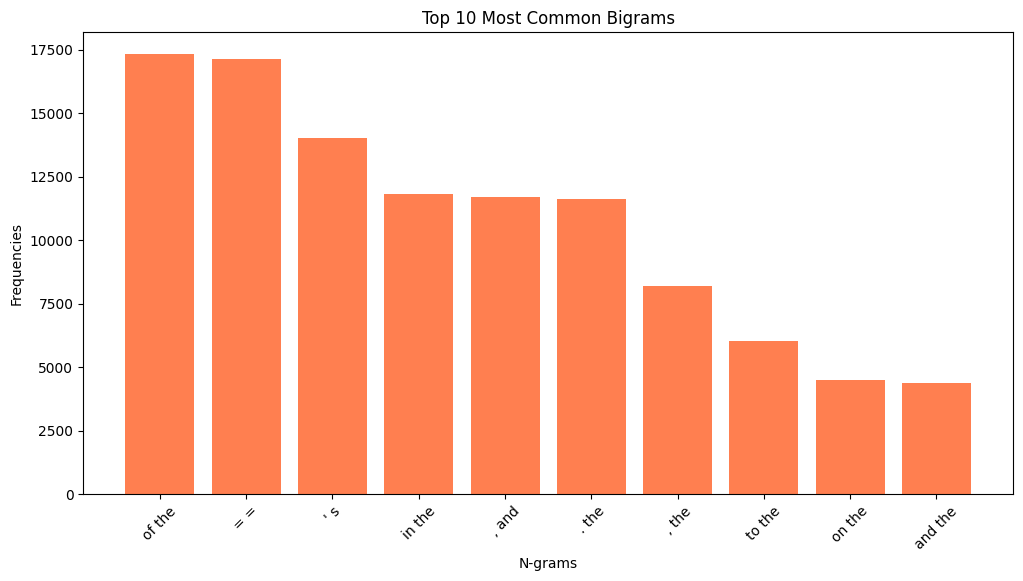

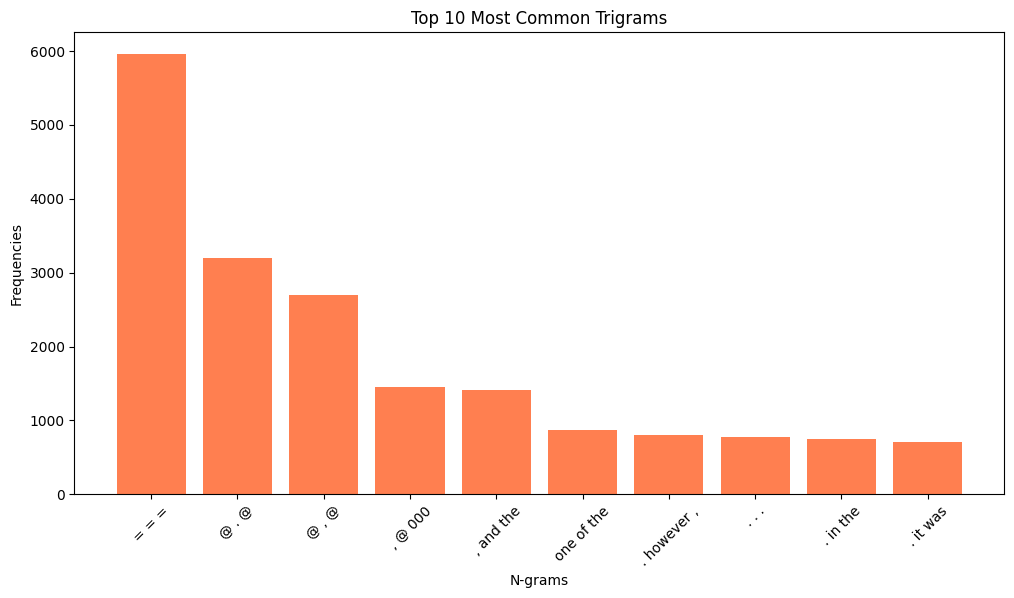

In [18]:
from collections import Counter
from itertools import islice

# a. Generate Unigrams, Bigrams, and Trigrams
def generate_ngrams(tokens_list, n):
    return zip(*[tokens_list[i:] for i in range(n)])

# b. Analyze the Most Common N-grams
def get_most_common_ngrams(counter, n=10):
    return counter.most_common(n)

# c. Visualize the Top N-grams
def plot_top_n_ngrams(counter, n=10, title='Top N-grams'):
    most_common = counter.most_common(n)
    ngrams, frequencies = zip(*most_common)
    
    # Convert tuples to strings for better visualization
    ngrams = [' '.join(ngram) for ngram in ngrams]
    
    plt.figure(figsize=(12, 6))
    plt.bar(ngrams, frequencies, color='coral')
    plt.title(title)
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.xticks(rotation=45)
    plt.show()

# Generate Unigrams (already done as word_counter)

# Generate Bigrams
bigram_counter = Counter()
for example in train_dataset:
    tokens = tokenizer(example['text'])
    bigrams = generate_ngrams(tokens, 2)
    bigram_counter.update(bigrams)

# Generate Trigrams
trigram_counter = Counter()
for example in train_dataset:
    tokens = tokenizer(example['text'])
    trigrams = generate_ngrams(tokens, 3)
    trigram_counter.update(trigrams)

# Get the top 10 most common Bigrams and Trigrams
top_10_bigrams = get_most_common_ngrams(bigram_counter, n=10)
top_10_trigrams = get_most_common_ngrams(trigram_counter, n=10)

# Print the most common Bigrams
print("\nTop 10 Most Common Bigrams:")
for bigram, freq in top_10_bigrams:
    print(f"{' '.join(bigram)}: {freq} occurrences")

# Print the most common Trigrams
print("\nTop 10 Most Common Trigrams:")
for trigram, freq in top_10_trigrams:
    print(f"{' '.join(trigram)}: {freq} occurrences")

# Visualize the top 10 Bigrams and Trigrams
plot_top_n_ngrams(bigram_counter, n=10, title='Top 10 Most Common Bigrams')
plot_top_n_ngrams(trigram_counter, n=10, title='Top 10 Most Common Trigrams')


## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [9]:
def data_process(raw_text_iter, batch_size, seq_len):
    # Tokenize and numericalize all tokens
    all_tokens = [vocab[token] for text in raw_text_iter for token in tokenizer(text["text"])]
    all_tokens = torch.tensor(all_tokens, dtype=torch.long)

    # Calculate the total number of full batches
    total_length = all_tokens.size(0)
    num_batches = total_length // (batch_size * seq_len)

    # Trim the tokens to fit exactly into full batches
    trimmed_length = num_batches * batch_size * seq_len
    all_tokens = all_tokens[:trimmed_length]  # Removed +1 to ensure divisibility

    # Reshape the data to (batch_size, num_batches * seq_len)
    data = all_tokens.view(batch_size, -1)

    # Create input and target sequences
    # Shift the data by one token for targets
    inputs = data[:, :-1].reshape(-1, seq_len)    # Shape: (M, L)
    targets = data[:, 1:].reshape(-1, seq_len)    # Shape: (M, L)

    return inputs, targets


In [10]:
# Parameters
batch_size = 64
seq_len = 64

# Process the training dataset
inputs, targets = data_process(train_dataset, batch_size, seq_len)

print(f'input shape: {inputs.shape}')
print(f'targets shape: {targets.shape}')


input shape: torch.Size([31999, 64])
targets shape: torch.Size([31999, 64])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [19]:
class LanguageModelDataset(Dataset):

    def __init__(self, inputs, targets):
        assert inputs.shape[0] == targets.shape[0], "Inputs and targets must have the same number of samples."
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [20]:
train_dataset = LanguageModelDataset(inputs, targets)

print(f'dataset length is: {len(train_dataset)}')

print(f'Example input sequence: {train_dataset[0][0]}')

print(f'Example target sequence: {train_dataset[0][1]}')

dataset length is: 31999
Example input sequence: tensor([   12,  3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,
         3890,    24,   785, 29473,     5,  6081,     6,  3874,     7,     4,
         5054,    90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,
          885,   634,   980,     5,    26,    11,  5692,   303,    15,   578,
          235,    70,   456,    22, 14003,     8,   758,     6,  2476,    20,
            4,  1759,  5677,     6,   158,     9,   248,   359,     9,   980,
            5,    27,    26,     4])
Example target sequence: tensor([ 3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,  3890,
           24,   785, 29473,     5,  6081,     6,  3874,     7,     4,  5054,
           90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,   885,
          634,   980,     5,    26,    11,  5692,   303,    15,   578,   235,
           70,   456,    22, 14003,     8,   758,     6,  2476,    20,     4,
         1759,  5677,     6,   

## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [21]:
def Get_dataLoaders(batch_size, seq_len):
    dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
    
    train_dataset = dataset['train']
    valid_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Create datasets
    train_inputs, train_targets = data_process(train_dataset, batch_size, seq_len)
    valid_inputs, valid_targets = data_process(valid_dataset, batch_size, seq_len)
    test_inputs, test_targets = data_process(test_dataset, batch_size, seq_len)
    
    # Create Dataset instances
    train_dataset = LanguageModelDataset(train_inputs, train_targets)
    valid_dataset = LanguageModelDataset(valid_inputs, valid_targets)
    test_dataset = LanguageModelDataset(test_inputs, test_targets)
    
    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataloader, valid_dataloader, test_dataloader


batch_size = 64
seq_len = 64
train_dataloader, valid_dataloader, test_dataloader = Get_dataLoaders(batch_size, seq_len)


# Verification: Print the number of batches in each DataLoader
print("\nDataLoaders Created:")
print(f"Number of Training Batches: {len(train_dataloader)}")
print(f"Number of Validation Batches: {len(valid_dataloader)}")
print(f"Number of Test Batches: {len(test_dataloader)}")


DataLoaders Created:
Number of Training Batches: 500
Number of Validation Batches: 52
Number of Test Batches: 59


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [22]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        super(LanguageModel, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Dropout layer after embedding
        self.dropout_emb = nn.Dropout(dropout_rate)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,  # Dropout between LSTM layers if multiple layers
            batch_first=True
        )
        
        # Dropout layer after LSTM
        self.dropout_lstm = nn.Dropout(dropout_rate)
        
        # Fully connected (linear) layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, src):
        # Pass the input through the embedding layer
        embedded = self.embedding(src)  # Shape: (batch_size, seq_len, embedding_dim)
        
        # Apply dropout after embedding
        embedded = self.dropout_emb(embedded)
        
        # Pass the embeddings through the LSTM layer
        lstm_out, _ = self.lstm(embedded)  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Apply dropout after LSTM
        lstm_out = self.dropout_lstm(lstm_out)
        
        # Reshape the LSTM output to (batch_size * seq_len, hidden_dim) for the fully connected layer
        lstm_out = lstm_out.contiguous().view(-1, lstm_out.shape[2])  # Shape: (batch_size * seq_len, hidden_dim)
        
        # Pass the reshaped output through the fully connected layer
        output = self.fc(lstm_out)  # Shape: (batch_size * seq_len, vocab_size)
        
        return output


In [23]:
# Define model parameters
vocab_size = len(vocab)
embedding_dim = 256
hidden_dim = 512
num_layers = 2
dropout_rate = 0.4

# Instantiate the model
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

# Example input (batch_size=128, seq_len=64)
example_input = torch.randint(0, vocab_size, (128, 64))  # Random tensor for demonstration

# Forward pass
output = model(example_input)  # Output shape: (128*64, vocab_size)

print(f'Output shape: {output.shape}')  # Should print: Output shape: torch.Size([8192, vocab_size])

print(f'model summary: {model}')

Output shape: torch.Size([8192, 66061])
model summary: LanguageModel(
  (embedding): Embedding(66061, 256)
  (dropout_emb): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.4)
  (dropout_lstm): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=66061, bias=True)
)


# 🔴 **Config**

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [25]:
# Define the optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()
metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)

# For language modeling, perplexity is a common metric, which is the exponential of the loss
def perplexity(loss):
    return torch.exp(loss)

# Summary of defined components
print("\nTraining Components:")
print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning Rate Scheduler: {scheduler}")
print(f"metric: {metric}")
print(f"Perplexity Function: {perplexity}")

model.to(device)


Training Components:
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Learning Rate Scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7c795450b010>
metric: MulticlassAccuracy()
Perplexity Function: <function perplexity at 0x7c7914081900>


LanguageModel(
  (embedding): Embedding(66061, 256)
  (dropout_emb): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.4)
  (dropout_lstm): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=66061, bias=True)
)

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [26]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets.view(-1))

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets.view(-1))

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [27]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets.view(-1))
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets.view(-1))

  return loss_eval.avg, metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [32]:
model = model.to(device)
model.eval()

inputs, targets = next(iter(train_dataloader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
    outputs = model(inputs)
    loss = criterion(outputs, targets.view(-1))  # Shape: (batch_size * seq_len)


print(loss)

tensor(11.1014, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [33]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [39]:
from torch.utils.data import Subset

small_subset_size = 1000  # Number of samples to use for overfitting
small_train_subset = Subset(train_dataset, range(small_subset_size))

small_train_dataloader = DataLoader(small_train_subset, batch_size=batch_size, shuffle=True)

In [40]:
num_epochs = 30

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, small_train_dataloader, criterion, optimizer, metric, epoch)
    train_losses.append(train_loss)
    valid_loss, _ = evaluate(model, valid_dataloader, criterion, metric)
    valid_losses.append(valid_loss)


Epoch 29: 100%|██████████| 16/16 [00:02<00:00,  5.57batch/s, loss=11, metric=0.067] 


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [43]:
num_epochs = 3

for lr in [0.1, 0.01, 0.001]:
    print(f'LR={lr}')

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

    for epoch in range(num_epochs):
        model, _, _ = train_one_epoch(model, train_dataloader, criterion, optimizer, metric, epoch)

    print(f'finished training with LR={lr}')

LR=0.1


Epoch 2: 100%|██████████| 500/500 [01:33<00:00,  5.37batch/s, loss=6.73, metric=0.14] 


finished training with LR=0.1
LR=0.01


Epoch 2: 100%|██████████| 500/500 [01:33<00:00,  5.36batch/s, loss=7.54, metric=0.0732]


finished training with LR=0.01
LR=0.001


Epoch 2: 100%|██████████| 500/500 [01:32<00:00,  5.40batch/s, loss=10.7, metric=0.0638]

finished training with LR=0.001


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [28]:
num_epochs = 3

for lr in [0.1, 0.01]:
  for wd in [0.001, 0.0001]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_dataloader, criterion, optimizer, metric, epoch)

    print(f'Finished training with LR = {lr}, WD = {wd}\n')

LR=0.1, WD=0.001


Epoch 2: 100%|██████████| 500/500 [01:31<00:00,  5.46batch/s, loss=7.53, metric=0.0664]


Finished training with LR = 0.1, WD = 0.001

LR=0.1, WD=0.0001


Epoch 2: 100%|██████████| 500/500 [01:32<00:00,  5.41batch/s, loss=7.52, metric=0.067] 


Finished training with LR = 0.1, WD = 0.0001

LR=0.01, WD=0.001


Epoch 2: 100%|██████████| 500/500 [01:31<00:00,  5.48batch/s, loss=10.6, metric=0.0638]


Finished training with LR = 0.01, WD = 0.001

LR=0.01, WD=0.0001


Epoch 2: 100%|██████████| 500/500 [01:32<00:00,  5.40batch/s, loss=10.6, metric=0.0638]

Finished training with LR = 0.01, WD = 0.0001



### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [29]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

In [30]:
lr = 0.1
wd = 0.0001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [31]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [34]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_dataloader,
                                                 criterion,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_dataloader,
                                     criterion,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 500/500 [01:33<00:00,  5.35batch/s, loss=7.68, metric=0.0857]


Model Saved!
Valid: Loss = 6.987, Metric = 0.1253



Epoch 1: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.91, metric=0.126]


Model Saved!
Valid: Loss = 6.756, Metric = 0.1472



Epoch 2: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.74, metric=0.139]


Model Saved!
Valid: Loss = 6.669, Metric = 0.1519



Epoch 3: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.64, metric=0.145]


Model Saved!
Valid: Loss = 6.574, Metric = 0.161



Epoch 4: 100%|██████████| 500/500 [01:33<00:00,  5.34batch/s, loss=6.57, metric=0.149]


Model Saved!
Valid: Loss = 6.516, Metric = 0.1636



Epoch 5: 100%|██████████| 500/500 [01:33<00:00,  5.35batch/s, loss=6.52, metric=0.152]


Model Saved!
Valid: Loss = 6.487, Metric = 0.1647



Epoch 6: 100%|██████████| 500/500 [01:33<00:00,  5.34batch/s, loss=6.48, metric=0.154]


Model Saved!
Valid: Loss = 6.451, Metric = 0.1651



Epoch 7: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.44, metric=0.155]


Model Saved!
Valid: Loss = 6.419, Metric = 0.1699



Epoch 8: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.41, metric=0.157]


Model Saved!
Valid: Loss = 6.391, Metric = 0.1705



Epoch 9: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.38, metric=0.159]


Model Saved!
Valid: Loss = 6.371, Metric = 0.1729



Epoch 10: 100%|██████████| 500/500 [01:33<00:00,  5.34batch/s, loss=6.36, metric=0.159]


Model Saved!
Valid: Loss = 6.36, Metric = 0.1711



Epoch 11: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.34, metric=0.16]


Model Saved!
Valid: Loss = 6.352, Metric = 0.1698



Epoch 12: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.32, metric=0.161]


Model Saved!
Valid: Loss = 6.325, Metric = 0.1747



Epoch 13: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.3, metric=0.162] 


Model Saved!
Valid: Loss = 6.303, Metric = 0.1757



Epoch 14: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.28, metric=0.163]


Model Saved!
Valid: Loss = 6.302, Metric = 0.1724



Epoch 15: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.27, metric=0.164]


Model Saved!
Valid: Loss = 6.274, Metric = 0.1784



Epoch 16: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.25, metric=0.164]


Valid: Loss = 6.274, Metric = 0.1761



Epoch 17: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.24, metric=0.165]


Model Saved!
Valid: Loss = 6.254, Metric = 0.1786



Epoch 18: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.23, metric=0.165]


Model Saved!
Valid: Loss = 6.249, Metric = 0.1791



Epoch 19: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.21, metric=0.166]


Model Saved!
Valid: Loss = 6.24, Metric = 0.1792



Epoch 20: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.2, metric=0.166] 


Model Saved!
Valid: Loss = 6.229, Metric = 0.1804



Epoch 21: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.19, metric=0.166]


Valid: Loss = 6.23, Metric = 0.1786



Epoch 22: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.18, metric=0.167]


Model Saved!
Valid: Loss = 6.212, Metric = 0.1803



Epoch 23: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.17, metric=0.167]


Model Saved!
Valid: Loss = 6.198, Metric = 0.1809



Epoch 24: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.16, metric=0.168]


Model Saved!
Valid: Loss = 6.195, Metric = 0.181



Epoch 25: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.15, metric=0.169]


Model Saved!
Valid: Loss = 6.187, Metric = 0.1828



Epoch 26: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.14, metric=0.17] 


Model Saved!
Valid: Loss = 6.177, Metric = 0.1841



Epoch 27: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.12, metric=0.17] 


Valid: Loss = 6.217, Metric = 0.1816



Epoch 28: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.11, metric=0.171]


Model Saved!
Valid: Loss = 6.163, Metric = 0.1834



Epoch 29: 100%|██████████| 500/500 [01:33<00:00,  5.33batch/s, loss=6.1, metric=0.172]


Model Saved!
Valid: Loss = 6.147, Metric = 0.1841



## 🟠 Main Loop

🔰 Define model.

In [35]:
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate).to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [36]:
lr = 0.1
wd = 0.0001
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [37]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 40

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_dataloader,
                                                 criterion,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_dataloader,
                                     criterion,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 500/500 [01:34<00:00,  5.30batch/s, loss=7.68, metric=0.0859]


Model Saved!
Valid: Loss = 6.979, Metric = 0.1239



Epoch 2: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.9, metric=0.126] 


Model Saved!
Valid: Loss = 6.755, Metric = 0.1455



Epoch 3: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.73, metric=0.138]


Model Saved!
Valid: Loss = 6.648, Metric = 0.1548



Epoch 4: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.63, metric=0.145]


Model Saved!
Valid: Loss = 6.577, Metric = 0.1569



Epoch 5: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.56, metric=0.149]


Model Saved!
Valid: Loss = 6.514, Metric = 0.1629



Epoch 6: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.51, metric=0.152]


Model Saved!
Valid: Loss = 6.476, Metric = 0.1658



Epoch 7: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.47, metric=0.154]


Model Saved!
Valid: Loss = 6.434, Metric = 0.1686



Epoch 8: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.43, metric=0.156]


Model Saved!
Valid: Loss = 6.41, Metric = 0.1686



Epoch 9: 100%|██████████| 500/500 [01:34<00:00,  5.30batch/s, loss=6.4, metric=0.158] 


Model Saved!
Valid: Loss = 6.39, Metric = 0.1697



Epoch 10: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.37, metric=0.159]


Model Saved!
Valid: Loss = 6.364, Metric = 0.1738



Epoch 11: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.35, metric=0.16]


Model Saved!
Valid: Loss = 6.344, Metric = 0.1733



Epoch 12: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.32, metric=0.161]


Model Saved!
Valid: Loss = 6.33, Metric = 0.1734



Epoch 13: 100%|██████████| 500/500 [01:33<00:00,  5.32batch/s, loss=6.3, metric=0.162] 


Model Saved!
Valid: Loss = 6.309, Metric = 0.1759



Epoch 14: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.29, metric=0.163]


Model Saved!
Valid: Loss = 6.303, Metric = 0.1757



Epoch 15: 100%|██████████| 500/500 [01:34<00:00,  5.32batch/s, loss=6.27, metric=0.164]


Model Saved!
Valid: Loss = 6.288, Metric = 0.178



Epoch 16: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.25, metric=0.164]


Model Saved!
Valid: Loss = 6.274, Metric = 0.179



Epoch 17: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.24, metric=0.165]


Model Saved!
Valid: Loss = 6.27, Metric = 0.1789



Epoch 18: 100%|██████████| 500/500 [01:34<00:00,  5.31batch/s, loss=6.23, metric=0.166]


Model Saved!
Valid: Loss = 6.25, Metric = 0.1786



Epoch 19:  65%|██████▍   | 324/500 [01:00<00:33,  5.27batch/s, loss=6.22, metric=0.166]

## 🟠 Plot

🔰 Plot learning curves

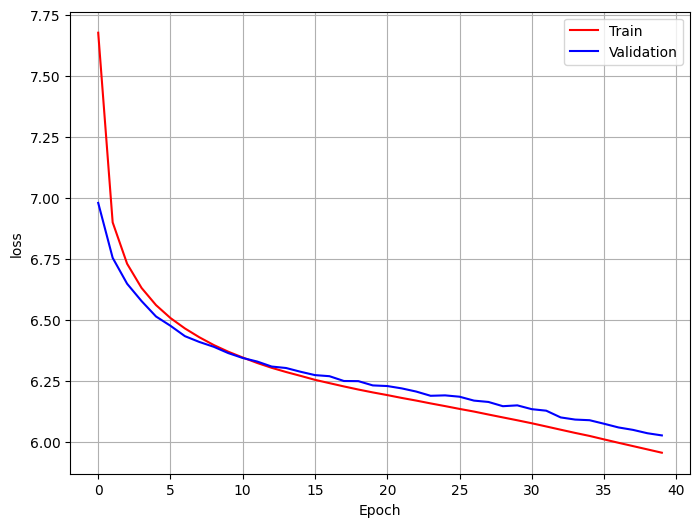

In [42]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# 🔴 **Test**

🔰 Test your model using data from the test set

In [44]:
model_path = 'model.pt'
model = torch.load(model_path)
model.to(device)

test_loss, test_metric = evaluate(model, test_dataloader, criterion, metric)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metric (Accuracy): {test_metric:.4f}")

Test Loss: 6.0422
Test Metric (Accuracy): 0.1939


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [45]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(66061, 256)
  (dropout_emb): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.4)
  (dropout_lstm): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=512, out_features=66061, bias=True)
)

In [50]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    tokens = tokenizer(prompt)
    token_ids = torch.tensor([vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0).to(device)

    model.eval()
    generated = token_ids.clone()

    with torch.inference_mode():
        for _ in range(max_seq_len):

            outputs = model(generated)
            logits = outputs[-1, :]
            logits = logits / temperature

            probabilities = torch.softmax(logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1).unsqueeze(0)
            generated = torch.cat([generated, next_token_id], dim=1)

            if next_token_id.item() == vocab["<eos>"]:
                break

    generated_tokens = [vocab.lookup_token(token_id) for token_id in generated.squeeze().tolist()]
    generated_text = " ".join(generated_tokens)

    return generated_text

In [51]:
prompt = "The weather is rainy tomorrow."
max_seq_len = 64
temperature = 1

generated_text = generate(prompt, max_seq_len, temperature, model, tokenizer, vocab)
print(f"Generated Text:\n{generated_text}")

Generated Text:
the weather is rainy tomorrow . the most ornamentation posada in neolithic entered for , 220 to be leonardo coupled complete levels . over 5 million campus the kakapo around reviving colonies and arne as this music ( ostensibly fischer ) chart of obstacles , california in 2007 , roughly . fragilis , welsh and slovenes , flew for much of these embryos . however , kipling continued to weak
